# Mathematico RL Agent 

This notebook contains configuration and code to train a neural network, which is integrated with a `Mathematico` agent to play the game.

In [1]:
%%capture
%load_ext autoreload
%autoreload 2

%pip install -Uq pip jupyter ipywidgets
%pip install install --quiet 'git+https://github.com/balgot/mathematico.git#egg=mathematico&subdirectory=game'
%pip install -q torch torchview torch-summary graphviz numpy matplotlib tqdm wandb

## Algorithm

Consider an agent **A** which is using MCTS and neural network *N* to find the
best move.

This algorithm works as follows: 

* play *M* games, recording the whole MCTS tree including all statistics and the final outcome (in the expert memory).
* sample *k* moves from the memory (experience replay), compute the loss between *N(s)* and expected reward and update the params of the network.

In [19]:
config = {
    "algorithm": "RL-td0-state(board)-separate_lines",  # rough description of the algorithm
    "name": "may-9th",  # wandb-run name
    "cuda": True,  # use CUDA if possible (beware of memory)
    
    # random related
    "seed": 0,
    "test_seed": 42,  # used for always measuring performance on the same games
    "test after . epochs": 15,  # how many epochs to train before conducting a tournament between agents
    
    # neural net
    "network": "hand crafted",  # name of the network to use
    
    ## pretraining on only final states
    "pretrain": "custom",
    
    ## Optimizer params
    "optimizer": "Adam",  # the only option
    "lr": 0.005,  # initial learning rate
    "betas": (0.9, 0.999),
    "weight-decay": 0.1,
    
    ## LR scheduler params
    "lr-scheduler": "ExponentialLR", # only option for now (used with ReduceLROnPlateau)
    "lr-gamma": 0.96,  
    
    ## gradient clipping
    "max-gradient-norm": 1,
    
    # about MCTS
    "time_limit": None,    # milliseconds
    "simuls_limit": 20, # per move
    "policy repeats": 1, # how many times to rerun the rollout policy
    "static_policy": False, # if True, policy just returns the value of the node
    
    # algo params
    "test_games": 10,
    "n_simulated_games": 5,  # at least 2 for stddev to exist
    "sample": True,  # do random sampling from data or just shuffle, the only option due to RAM contraints
    "batch_size": 256,  # only applicable if "sample" = True
    "n_training_loops": 64, # per one RL epoch
    "n_epochs": 200,

    # loss function calculation
    "alpha": 1,  # how well do we approximate MCTS
    "beta": 0,  # discounted final score approximation
    "target-scale": 1.005,  # make neural network to overpredict
}

assert config["optimizer"] == "Adam"
assert config["lr-scheduler"] == "ExponentialLR"
assert config["n_simulated_games"] > 1

In [20]:
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))

import random
import statistics
from copy import deepcopy
import time
import math
import warnings

import torch
from torchview import draw_graph
from torchsummary import summary
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import graphviz
graphviz.set_jupyter_format('png')  # VS code fix for cropped images from torchview

import mathematico
from src.utils import mcts
from src.utils.extract_data import extract
from src.utils.symmetries import all_symmetries
import src.nets as nets
from src.utils.lr import display_learning_rate


import wandb
wandb.init(config=config, project="PA026", name=config.get("name", None), settings=wandb.Settings(start_method="fork"))


########################################
# random seed
########################################

# note that especially when using CUDA, this is not enough for deterministic computation, see torch docs
torch.random.manual_seed(config["seed"])
random.seed(config["seed"])
np.random.seed(config["seed"])


########################################
# cuda settings
########################################

if not config["cuda"]:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
dev = torch.device("cuda") if torch.cuda.is_available() and config["cuda"] else torch.device("cpu")
dev

device(type='cuda')

### Neural Network Definition

First just processing the lines:

In [4]:
class MyModel(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mm = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(5*14, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(1024, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 1)
        )

    def forward(self, b):
        one_hot = torch.nn.functional.one_hot(b.long(), 14)
        return self.mm(one_hot.float())
    
    
line_model = MyModel().to(dev)
summary(line_model, [5], depth=3);

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Flatten: 2-1                      [-1, 70]                  --
|    └─Linear: 2-2                       [-1, 1024]                72,704
|    └─ReLU: 2-3                         [-1, 1024]                --
|    └─Dropout: 2-4                      [-1, 1024]                --
|    └─Linear: 2-5                       [-1, 1024]                1,049,600
|    └─ReLU: 2-6                         [-1, 1024]                --
|    └─Dropout: 2-7                      [-1, 1024]                --
|    └─Linear: 2-8                       [-1, 512]                 524,800
|    └─ReLU: 2-9                         [-1, 512]                 --
|    └─Linear: 2-10                      [-1, 1]                   513
Total params: 1,647,617
Trainable params: 1,647,617
Non-trainable params: 0
Total mult-adds (M): 3.29
Input size (MB): 0.00
Forward/backwa

Then for combining the results:

In [5]:
class CombineModel(torch.nn.Module):
    def __init__(self, line_prep, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.line_prep = line_prep
        self.out = torch.nn.Sequential(
            torch.nn.Linear(5 + 5 + 1 + 1 + 25, 1024),
            torch.nn.ReLU(),
            torch.nn.Dropout(),
            torch.nn.Linear(1024, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 1)
        )

    def forward(self, board: torch.Tensor):
        mask = (board == 0).float()
        mask = torch.flatten(mask, start_dim=1)
        
        # rows of the board
        rows = []
        for i in range(5):
            row = board[:, i, :]
            rows.append(self.line_prep(row))

        # cols of the board
        cols = []
        trans = board.transpose(-1, -2)
        for i in range(5):
            col = trans[:, i, :]
            cols.append(self.line_prep(col))

        # main/anti diagonal
        main = board.diagonal(0, -2, -1)[:, :]
        anti = torch.flip(board, [-2, -1]).diagonal(0, -2, -1)[:, :]
        main = self.line_prep(main)
        anti = self.line_prep(anti)

        catted = torch.cat([*rows, *cols, main, anti, mask], dim=-1)
        return self.out(catted)
    
    
model = CombineModel(line_model).to(dev)
summary(model, [(5, 5)], depth=3);

Layer (type:depth-idx)                   Output Shape              Param #
├─MyModel: 1-1                           [-1, 1]                   --
|    └─Sequential: 2-1                   [-1, 1]                   --
|    |    └─Flatten: 3-1                 [-1, 70]                  --
|    |    └─Linear: 3-2                  [-1, 1024]                72,704
|    |    └─ReLU: 3-3                    [-1, 1024]                --
|    |    └─Dropout: 3-4                 [-1, 1024]                --
|    |    └─Linear: 3-5                  [-1, 1024]                1,049,600
|    |    └─ReLU: 3-6                    [-1, 1024]                --
|    |    └─Dropout: 3-7                 [-1, 1024]                --
|    |    └─Linear: 3-8                  [-1, 512]                 524,800
|    |    └─ReLU: 3-9                    [-1, 512]                 --
|    |    └─Linear: 3-10                 [-1, 1]                   513
├─MyModel: 1-2                           [-1, 1]                   (

In [25]:
# draw_graph(model, input_data=_board_batch, depth=3, graph_dir="LR").visual_graph

### Pretraining of Nets

#### Line Model

In [7]:
from itertools import product
from collections import Counter
from mathematico.game.eval import evaluate_line


available = list(range(14))
states = {}
for line_data in tqdm(product(available, available, available, available, available), total=14**5):
    key = tuple(line_data)
    ctr = Counter(line_data)
    if ctr.most_common(n=1)[0][1] > 4 and 0 not in ctr:
        continue  # dont care about forbidden states
    del ctr[0]
    states[key] = evaluate_line(ctr)

  0%|          | 0/537824 [00:00<?, ?it/s]

In [8]:
len(states), 14**5

(537811, 537824)

In [9]:
from torch.utils.data import Dataset, TensorDataset, DataLoader

data_tensors = []
target_tensors = []
for data, target in tqdm(states.items(), total=len(states)):
    data_tensors.append(torch.tensor(data, device=dev))
    target_tensors.append(torch.tensor(target, device=dev, dtype=torch.float))

dataset = TensorDataset(torch.stack(data_tensors), torch.stack(target_tensors))

  0%|          | 0/537811 [00:00<?, ?it/s]

In [10]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(line_model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

# set model to training mode
line_model.train()
losses = []
lr = []

dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
for epoch in (pbar := trange(256, desc="Pretraining")):
    _loss_avg = 0

    for i, (X_batch, y_batch) in enumerate(tqdm(dataloader, leave=None)):
        y_pred = line_model(X_batch)
        loss = loss_fn(y_pred, y_batch.reshape_as(y_pred))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _loss_avg += loss

    losses.append(_loss_avg.mean().cpu().detach().numpy())
    scheduler.step(losses[-1])
    lr.append(optimizer.param_groups[0]['lr'])
    pbar.set_description(f"Pretraining (loss: {losses[-1]:.02f}) [lr: {lr[-1]:.1E}]")
    
    if lr[-1] < 1e-8:
        print("lr too low, stopping...")
        break

Pretraining:   0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.


  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

Epoch 00150: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

Epoch 00212: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

Epoch 00244: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

  0%|          | 0/2101 [00:00<?, ?it/s]

Epoch 00255: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/2101 [00:00<?, ?it/s]

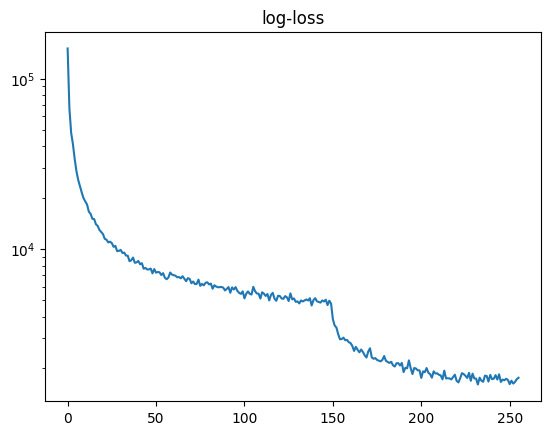

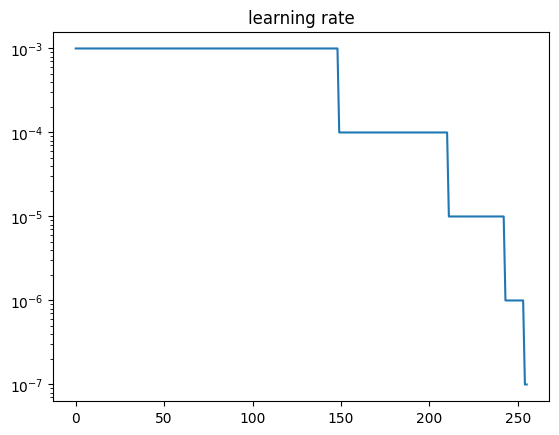

     [0, 0, 0, 0, 0]	0.0	-24.923053741455078
     [0, 0, 1, 0, 1]	0.0	5.144474983215332
     [0, 0, 2, 0, 2]	0.0	1.2954988479614258
     [0, 0, 3, 0, 3]	0.0	-2.806033134460449
     [0, 0, 4, 0, 4]	0.0	4.054852485656738
     [0, 0, 5, 0, 5]	0.0	6.4408464431762695
     [0, 0, 6, 0, 6]	0.0	4.644833564758301
     [0, 0, 7, 0, 7]	0.0	4.296757698059082
     [0, 0, 8, 0, 8]	0.0	8.527050971984863
     [0, 0, 9, 0, 9]	0.0	0.753697395324707
   [0, 0, 10, 0, 10]	0.0	-0.877619743347168
   [0, 0, 11, 0, 11]	0.0	5.031628608703613
   [0, 0, 12, 0, 12]	0.0	1.6265535354614258
   [0, 0, 13, 0, 13]	0.0	1.7850618362426758
     [0, 1, 0, 1, 0]	0.0	-3.2979307174682617
     [0, 1, 1, 1, 1]	0.0	-0.7458677291870117
     [0, 1, 2, 1, 2]	80.0	82.54964447021484
     [0, 1, 3, 1, 3]	80.0	79.8072509765625
     [0, 1, 4, 1, 4]	80.0	78.86013793945312
     [0, 1, 5, 1, 5]	80.0	81.02287292480469
     [0, 1, 6, 1, 6]	80.0	80.6181640625
     [0, 1, 7, 1, 7]	80.0	78.9631576538086
     [0, 1, 8, 1, 8]	80.0	81.7417602539062

In [11]:
plt.plot(losses)
ax = plt.gca()
ax.set_yscale('log')
ax.set_title("log-loss")
plt.show()

plt.plot(lr)
ax = plt.gca()
ax.set_yscale('log')
ax.set_title("learning rate")
plt.show()

for i in range(50):
    x, y = dataset[i*197]
    print(f"{str(x.cpu().detach().tolist()):>20}\t{y.cpu().numpy()}\t{line_model(x.unsqueeze(0)).cpu().detach().numpy()[0][0]}")

#### The Large Model

In [12]:
losses = []
lr = []

o = torch.optim.Adam(model.parameters(), lr=1e-3)
s = torch.optim.lr_scheduler.ReduceLROnPlateau(o)
deck = [i for i in range(1, 14) for _ in range(4)]

for epoch in (pbar := trange(256, desc="Pretraining")):
    batch_loss = 0
    for barch in trange(64, leave=None, desc="batch #"):
        boards = []
        vals = []
        for _ in range(512):
            random.shuffle(deck)
            b = mathematico.Board()
            for r in range(5):
                for c in range(5):
                    b.make_move((r, c), deck[5*r + c])
            boards.append(b.grid)
            vals.append(b.score())

        _loss_fn = torch.nn.MSELoss()
        o.zero_grad()
        outs = model(torch.tensor(boards, device=dev))
        target = torch.tensor(vals, device=dev, dtype=outs.dtype).reshape_as(outs)
        loss = _loss_fn(outs, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.5)
        o.step()
        batch_loss += loss.detach() / 64
        
    s.step(batch_loss)
    
    if torch.any(torch.isnan(batch_loss)):
        print("NaN detected...")
        break
    
    losses.append(batch_loss.cpu().detach().numpy())
    lr.append(o.param_groups[0]['lr'])
    pbar.set_description(f"Pretraining (loss: {losses[-1]:.02f}) [lr: {lr[-1]:.1E}]")  


Pretraining:   0%|          | 0/256 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

batch #:   0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

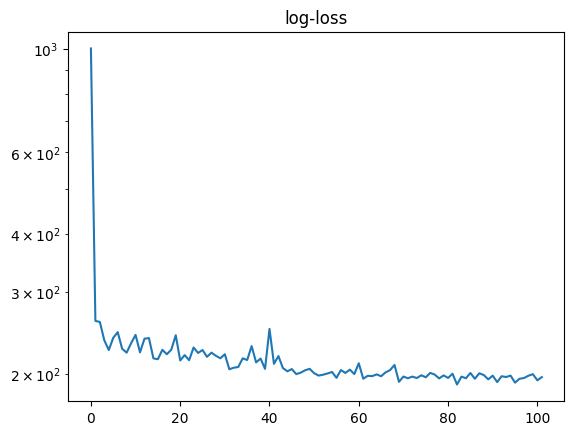

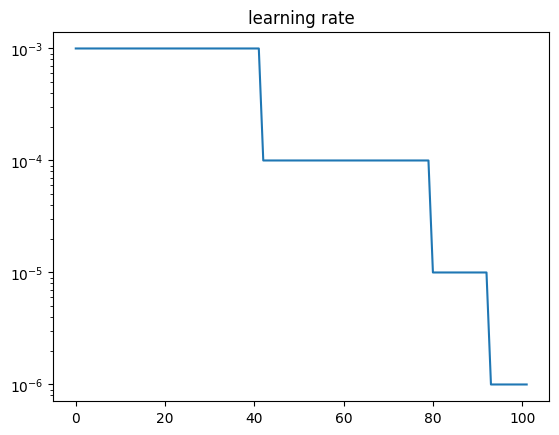

+--+--+--+--+--+
| 1| 2| 3| 4| 5|
+--+--+--+--+--+
| 1| 2| 3| 4| 5|
+--+--+--+--+--+
| 1| 2| 3| 4| 5|
+--+--+--+--+--+
| 1| 2| 3| 4| 5|
+--+--+--+--+--+
| 6| 7| 8| 9|10|
+--+--+--+--+--+
Real = 1150	Predicted = 700.755
Real = 60	Predicted = 53.302
Real = 180	Predicted = 160.647
Real = 80	Predicted = 89.003
Real = 90	Predicted = 70.046
Real = 100	Predicted = 89.675
Real = 70	Predicted = 79.661
Real = 100	Predicted = 106.269
Real = 70	Predicted = 81.160
Real = 80	Predicted = 61.758
Real = 40	Predicted = 53.146
Real = 50	Predicted = 62.138
Real = 110	Predicted = 97.529
Real = 50	Predicted = 61.875
Real = 210	Predicted = 191.345
Real = 100	Predicted = 89.363
Real = 160	Predicted = 154.493
Real = 270	Predicted = 219.133
Real = 30	Predicted = 43.342
Real = 130	Predicted = 127.755
Real = 50	Predicted = 62.525
Real = 40	Predicted = 53.276
Real = 70	Predicted = 62.489
Real = 70	Predicted = 61.605
Real = 50	Predicted = 43.517
Real = 120	Predicted = 105.882


In [13]:
plt.plot(losses)
ax = plt.gca()
ax.set_yscale('log')
ax.set_title("log-loss")
plt.show()

plt.plot(lr)
ax = plt.gca()
ax.set_yscale('log')
ax.set_title("learning rate")
plt.show()

_set = [[1,2,3,4,5]]*4 + [[6,7,8,9,10]]
_b = mathematico.Board()
for r in range(5):
    for c in range(5):
        _b.make_move((r, c), _set[r][c])
print(_b)

with torch.no_grad():
    model.eval()
    print(f"Real = {_b.score()}\tPredicted = {model(torch.tensor([_set], device=dev)).cpu().numpy()[0][0]:.3f}")
    
    
for _ in range(25):
    _b = mathematico.Board()
    _deck = [k for k in range(1, 14) for _ in range(4)]
    random.shuffle(_deck)
    for i in range(5):
        for j in range(5):
            _b.make_move((i, j), _deck[5*i+j])

    # print(_b)
    with torch.no_grad():
        model.eval()
        print(f"Real = {_b.score()}\tPredicted = {model(torch.tensor([_b.grid], device=dev)).cpu().numpy()[0][0]:.3f}")

#### Save Models

In [14]:
torch.save(line_model.state_dict(), "line_model_longer.pt")
torch.save(model.state_dict(), "whole_model_longer.pt")

### Agent

In [21]:
from src.agents.mcts_player import MctsPlayer, CardState, MoveState

def policy_static(state: mcts.StateI) -> float:
    board = torch.tensor([state.board.grid], device=dev)
    return model(board)


def policy_dynamic(state: mcts.StateI) -> float:
    _board = deepcopy(state.board)
    _possible_moves = set(_board.possible_moves())
    _deck = [k for k, v in state.deck.items() for _ in range(v)]
    random.shuffle(_deck)
    
    def mmove(move, card):
        b = deepcopy(_board.grid)
        b[move[0]][move[1]] = card
        return b
    
    with torch.no_grad():
        for i in range(len(_possible_moves)):
            batch = torch.tensor([
                mmove(move, _deck[i]) for move in _possible_moves
            ], device=dev)
            out = model(batch)
            idx = torch.argmax(out)
            move = list(_possible_moves)[idx]
            _board.make_move(move, _deck[i])
            _possible_moves.discard(move)
        return _board.score()
            
        
        
def repeated_dynamic(state):
    total = 0
    REPS = config['policy repeats']
    for _ in range(REPS):
        total += policy_dynamic(state)
    return total / REPS       
    


agent = MctsPlayer(
    max_time_ms=config["time_limit"], 
    max_simulations=config["simuls_limit"], 
    policy=policy_static if config["static_policy"] else repeated_dynamic
)

check it works by playing a random game

In [22]:
%%time

start = time.time()
arena = mathematico.Arena()
arena.add_player(agent)
arena.run(seed=0, rounds=1, verbose=True)
end = time.time()

per_move_sec = (end - start) / (5 * 5)
print(f"{per_move_sec=}")

Steps run: 1	Elapsed time: 24.1860773563385
per_move_sec=0.9674678039550781
CPU times: user 24.2 s, sys: 20 ms, total: 24.3 s
Wall time: 24.2 s


## Training

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"], betas=config["betas"], weight_decay=config["weight-decay"])
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config["lr-gamma"])
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

#### Utils

In [23]:
class VNPlayer(mathematico.Player):
    def reset(self):
        self.board = mathematico.Board()
        
    def move(self, card: int) -> None:
        possibles = list(self.board.possible_moves())
        
        def place(row, col):
            _g = deepcopy(self.board.grid)
            _g[row][col] = card
            return _g
        
        batch = torch.tensor([place(row, col) for row, col in possibles], device=dev)
        scores = model(batch)
        idx = torch.argmax(scores)
        row, col = possibles[idx]
        self.board.make_move((row, col), card)


def _eval_against_players(agent, model, rounds):
    """
    Evaluate the agent against:
        1. random player
        2. mcts player with same time for a game (not very precise..)
        3. mcts with same number of simuls
        4. only value network
        
    Returns:
        win rate for 1, 2, 3, 4
        avg score for 1, 2, 3, 4
        descriptions
        ranking value (avg number of player defeated)
    """
    model.eval()
    players = [
        agent, 
        mathematico.RandomPlayer(), 
        MctsPlayer(max_time_ms=per_move_sec * 1000),
        MctsPlayer(max_simulations=config["simuls_limit"]),
        VNPlayer()
    ]
    
    desc = ["vn+mcts player", "random", "mcts(time)", "mcts(simuls)", "value net"]
    
    wins_agains = [0 for _ in players]
    total_score = [0 for _ in players]
    rank = 0
    
    for _round in trange(rounds, desc="Evaluating performance tournament", leave=None):
        game = mathematico.Mathematico(seed=_round + config["test_seed"])
        for player in players:
            player.reset()
            game.add_player(player)
            
        scores = game.play()
        
        # first is always our agent
        for i in range(len(scores)):
            if scores[0] >= scores[i]:
                wins_agains[i] += 1
                
        for i in range(len(scores)):
            total_score[i] += scores[i]
            
        rank += sum(scores[0] >= scores[i] for i in range(1, len(scores)))
        
    rank /= (rounds * (len(players) - 1))
    return [w/rounds for w in wins_agains], [s/rounds for s in total_score], desc, rank


def _log(start_time, mean, std, min_score, max_score, it, loss, loss_mcts, loss_final):
    # assert torch.isclose(loss_mcts + loss_final + loss_max, loss)
    
    duration = time.time() - start_time
    log_dict = {
        "time": duration,
        "mean": mean,
        "std": std,
        "min score": min_score,
        "max score": max_score,
        "loss": loss,
        "loss [mcts]": loss_mcts,
        "loss [final]": loss_final,
        "lr": optimizer.param_groups[0]['lr']  # valid only with one param group for optimizer
    }

    if it % config["test after . epochs"] == 0:
        wins, scores, desc, rank = _eval_against_players(agent, model, rounds=config["test_games"])
        for d, w, s in zip(desc, wins, scores):
            log_dict[d + " wins %"] = w
            log_dict[d + " [[avg score]]"] = s
        log_dict["rank"] = rank
        
    wandb.log(log_dict)



def learn_episode(agent: MctsPlayer, model: torch.nn.Module, n_games, batch_size, m_training):
    expert_memory = []   
    
    # for logging..
    _scores = []
    loss = 0
    loss_mcts = 0
    loss_final = 0

    #############################################################################
    #                           playing phase
    #############################################################################
    
    model.eval()
    for game in trange(n_games, desc="Game playing phase", leave=None, position=1):
        agent.reset()
        cards = [i for i in range(1, 13+1) for _ in range(4)]
        random.shuffle(cards)

        # game memory - all states visited during mcts
        game_memory = []
        
        # which states were actually played
        true_states = []

        # play all the moves till the end
        for move in trange(5*5, desc="Playing moves", leave=None, position=2):
            state = deepcopy(agent.board.grid)
            card = cards[move]
            estimate, root = agent.move_(card)
            visited_states = extract(root)
            for b, e, v, d, h in visited_states:
                for s in all_symmetries(b):
                    game_memory.append((s, e, v, d, h))
            true_states.append(visited_states[0])

        final_score = agent.board.score()
        _scores.append(final_score)
        
        for board, exp, visits, depth, height in true_states:
            for s in all_symmetries(board):
                expert_memory.append((s, final_score, exp, visits, depth, height))
        for b, e, v, d, h in game_memory:
            expert_memory.append((b, None, e, v, d, h))

            
    #############################################################################
    #                           training phase
    #############################################################################
    
    model.train()
    weights = [entry[3] for entry in expert_memory]  # visit counts
    _s = sum(weights)
    weights = [w/_s for w in weights]
    indices = np.random.choice(len(expert_memory), size=(m_training, batch_size), replace=m_training*batch_size > len(expert_memory), p=weights)
    
    for train in trange(m_training, desc="Training loop", leave=None, position=1):
        batch = [expert_memory[idx] for idx in indices[train]]
        
        for with_final in (True, False):  # two passes, one for played states, one for hypothetical        
            boards, reals, exps, viss, deps, heis = [], [], [], [], [], []
            for b, real, exp, vis, dep, hei in batch:
                if (real is not None) == with_final:
                    boards.append(b)
                    reals.append(real)
                    exps.append(exp)
                    viss.append(vis)
                    deps.append(dep)
                    heis.append(hei)

            if boards:                
                
                optimizer.zero_grad()
                outs = torch.squeeze(model(torch.tensor(boards, device=dev)), dim=1)
                target = config["target-scale"] * torch.tensor(exps, device=dev)
                
                _mcts_loss_norm = torch.log(torch.tensor(viss, device=dev) + 1) / (torch.tensor(heis, device=dev) + 1)
                _mcts_loss = torch.mean(config["alpha"] * _mcts_loss_norm * (target - outs)**2)
                
                _final_coef = (math.log(2) + 1) / (1 + torch.log(1 + torch.tensor(heis, device=dev)))
                _final_loss = 0 if not with_final else torch.mean(config["beta"] * _final_coef * _mcts_loss_norm * (torch.tensor(reals, device=dev) - outs)**2)
                
                _loss = _mcts_loss + _final_loss
                
                if torch.any(torch.isnan(_loss)):
                    raise RuntimeError("NaN detected, instable learning..." + f"{_mcts_loss_norm=}\t{_mcts_loss=}\t{_final_loss=}")
                    
                _loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config["max-gradient-norm"]) 
                optimizer.step()
                
                with torch.no_grad():
                    loss += _loss / m_training
                    loss_mcts += _mcts_loss / m_training
                    if with_final:
                        loss_final += _final_loss / m_training
            
    scheduler1.step()  
    scheduler2.step(loss_mcts)
    
    return (
        statistics.mean(_scores), 
        statistics.stdev(_scores),
        min(_scores),
        max(_scores),
        loss,
        loss_mcts,
        loss_final
    )


## Training

In [27]:
START = time.time()

# _log(START, None, None, None, None, 0, None, None, None)
for epoch in trange(1, 1+config["n_epochs"], desc="Epochs"):
    mean, std, mini, maxi, L, Lm, Lf = learn_episode(
        agent, 
        model, 
        n_games=config["n_simulated_games"], 
        batch_size=config["batch_size"], 
        m_training=config["n_training_loops"]
    ) 
    
    
    
    if torch.any(torch.isnan(L)) or torch.any(torch.isnan(Lm)):
        print("Instabilities (NaN), aborting...")
        break
    _log(START, mean, std, mini, maxi, epoch, L, Lm, Lf)
    
    # form of early stopping
    if optimizer.param_groups[0]['lr'] < 1e-8:
        print(f"[{epoch=}] Learning rate is too low, aborting...")
        break

Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating performance tournament:   0%|          | 0/10 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating performance tournament:   0%|          | 0/10 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [28]:
torch.save(model.state_dict(), "trained_o4299lc5.pt")

In [ ]:
_log(START, None, None, None, None, 100*config['test after . epochs'], None, None, None)
wandb.finish()

## Evaluation

Create a random game and observe, how the predictions change over time:

In [ ]:
import pprint

model.eval()
agent.reset()

cards = [i for i in range(1, 13+1) for _ in range(4)]
random.shuffle(cards)
true_states = []

# play all the moves till the end
for move in trange(5*5, desc="Playing moves", leave=True):
    state = deepcopy(agent.board.grid)
    card = cards[move]
    _, root = agent.move_(card)
    visited_states = extract(root)
    true_states.append(visited_states[0])

final_score = agent.board.score()
for board, exp, visits, depth, height in true_states:
    with torch.no_grad():
        print("\n\n")
        pprint.pprint(board)
        print(f"expected (mcts) score  {exp:>20.1f}")
        print(f"computed (vn) score    {model(torch.tensor([b])).numpy()[0][0]:>20.1f}")
        print(f"game (true) score      {final_score:>20.1f}")
        print(f"{visits=}\t{dep=}\t{height=}")